# MESA session 3: solution notebook


In [1]:
import os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const


***
# Problem 1 Energy production in massive stars

In [2]:
# Load your computed models
history15 = mr.MesaData('./data/session3_workingdir/M15_HW3/history.data')
history20 = mr.MesaData('./data/session3_workingdir/M20_HW3/history.data')
history30 = mr.MesaData('./data/session3_workingdir/M30_HW3/history.data')
history40 = mr.MesaData('./data/session3_workingdir/M40_HW3/history.data')
history60 = mr.MesaData('./data/session3_workingdir/M60_HW3/history.data')


In [3]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None),
               VMIN=-3, VMAX=0, cmap_name = 'rainbow', Lfrac=False,
               colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):

    fig, ax = plt.subplots(figsize=(10, 8))
    # scat = None

    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:]
        C        = np.asarray(getattr(hist, colour_by))[start:]

        if Lfrac:
            # e.g. colour_by='log_LH' -> 10**log_LH / 10**log_L = L_H / L_tot
            C = np.power(10.0, C) / np.power(10.0, log_L)

        scat = ax.scatter(log_Teff, log_L, c=C, cmap = cmap_name, vmin=VMIN, vmax=VMAX, s=8)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], log_L[0], marker='*', s=50)
        ax.text(log_Teff[0],  log_L[0] , f"${np.round(hist.star_mass[0], 0)}$"+"M$_{\odot}$", ha='right', va='top') #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()

    os.makedirs(save_loc, exist_ok=True)
    out = os.path.join(save_loc, f"HR_{'Lfrac_'+colour_by if Lfrac else colour_by}.png")
    plt.savefig(out, bbox_inches='tight')
    plt.show(); plt.close()
    return out


In [14]:
# history15.header_names
# history15.bulk_names
# history15.version_number

In [5]:
histoy_list = [history15, history20, history30, history40, history60]
# HistNameList   = ['15 M$_{\odot}$', '20 M$_{\odot}$', '30 M$_{\odot}$', '40 M$_{\odot}$', '60 M$_{\odot}$']
colors = plt.cm.plasma(np.linspace(0,1,4)) #3rd num is the number of colours Set2

## H, He and Z luminosity as a fraction of the total L

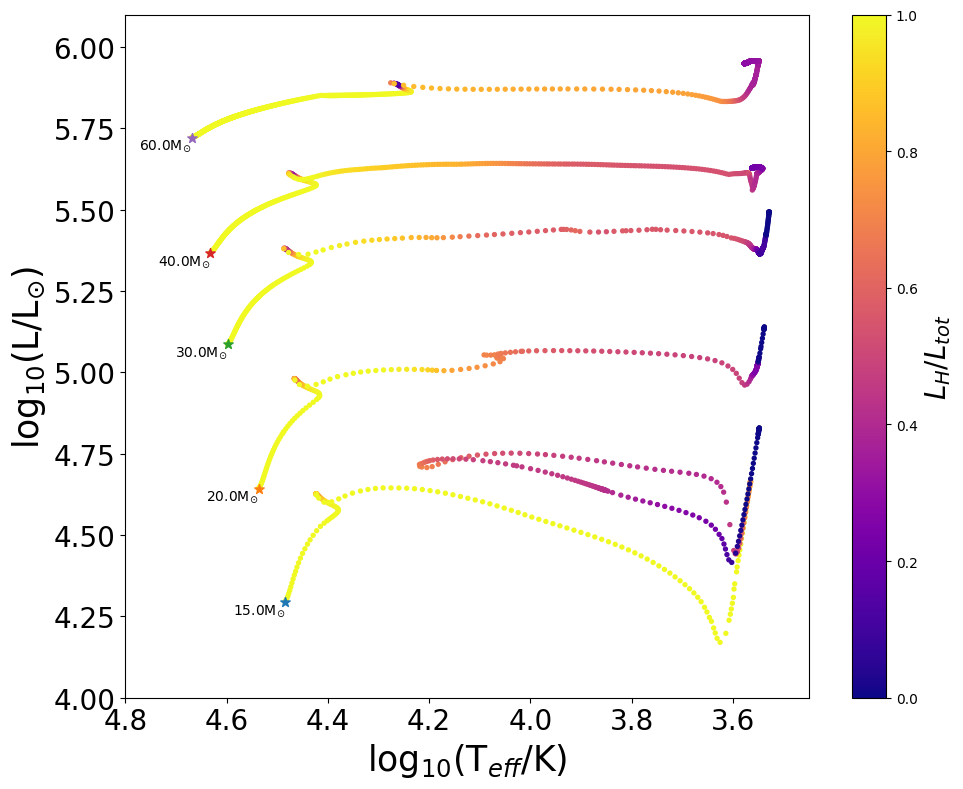

'./plots/HR_Lfrac_log_LH.png'

In [8]:
HR_diagram(histoy_list,
           xlim=(3.45, 4.8), ylim=(4.0, 6.1),
           VMIN=0, VMAX=1, cmap_name = 'plasma', Lfrac=True,
           colour_by='log_LH', colour_label='$L_{H}$/$L_{tot}$')


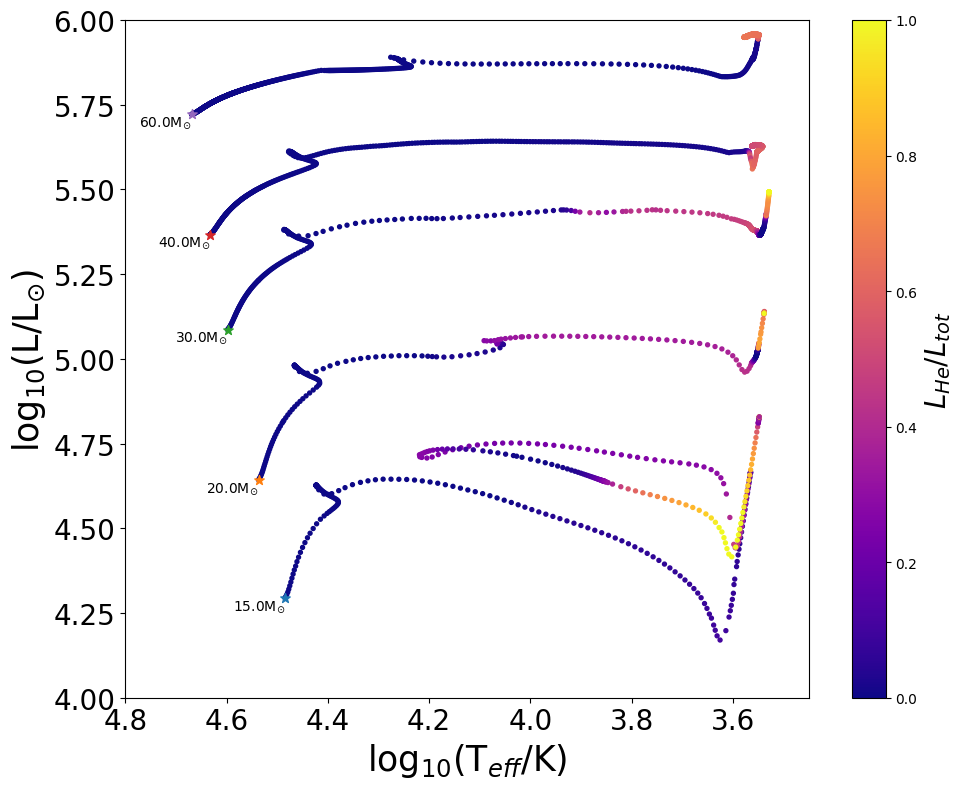

'./plots/HR_Lfrac_log_LHe.png'

In [9]:
# make plot
HR_diagram(histoy_list, xlim = (3.45,4.8), ylim= (4.,6.), VMIN =0, VMAX = 1,
         Lfrac = True, colour_by = 'log_LHe', 
          cmap_name = 'plasma', colour_label = '$L_{He}$/$L_{tot}$')


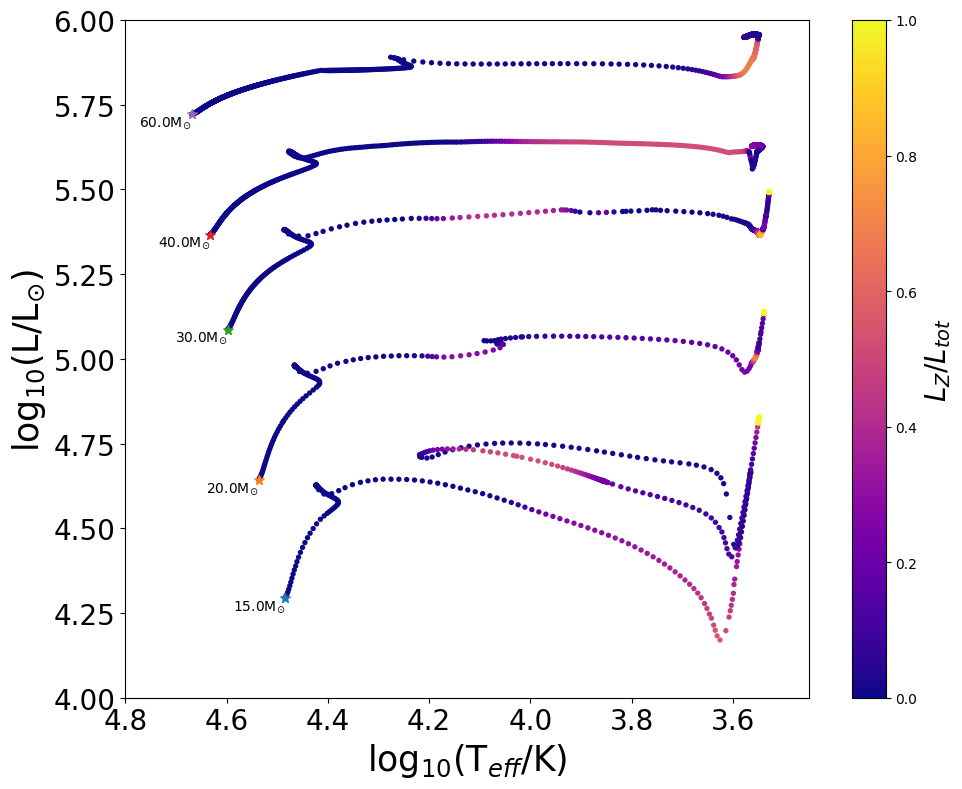

'./plots/HR_Lfrac_log_LZ.png'

In [13]:
# make plot
HR_diagram(histoy_list, xlim = (3.45,4.8), ylim= (4.,6.), VMIN =0, VMAX = 1, 
            Lfrac = True, colour_by = 'log_LZ', 
            cmap_name = 'plasma', colour_label = '$L_{Z}$/$L_{tot}$')

## Now we'll show it per dominating Luminosity

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
ColorSet = plt.cm.Set2(np.linspace(0,1,8)) #3rd num is the number of colours Set2
# colors = ColorSet[0:4]
colors = [ColorSet[0],ColorSet[1],ColorSet[3],ColorSet[2]] # switch last 2 colors
newcmp = ListedColormap(colors)

#Plot the HR diagram with different colour values
def HR_diagram(histoy_list, xlim = (None, None), ylim = (None,None),  VMIN =-3, VMAX = 0, Ldominant = True,
               colour_by = 'center_h1', colour_label = 'kleur',save_loc = proj_dir + '/hw4sol/plots/'):
    
    kleur = colour_by
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.699)
        hist = hist[ZAMS_i:]
        #Express the luminosity as a fraction of the total luminosity
        if Ldominant:
            L_dominant = np.argmax([10**hist['log_LH']/10**hist['log_L'], 10**hist['log_LHe']/10**hist['log_L'],\
                                    10**hist['log_LZ']/10**hist['log_L'], np.full(len(hist),0.5) ], axis = 0 )
            hist['L_dominant'] = L_dominant
            kleur = 'L_dominant'
        ##plot lines
        scat = ax.scatter(hist['log_Teff'],  hist['log_L'] , label= hist_names[i],
                c = hist[kleur], vmin= VMIN, vmax = VMAX, cmap = newcmp)
        ax.scatter(hist['log_Teff'][0],  hist['log_L'][0] , marker = '*') #log_Teff
        ax.text(hist['log_Teff'][0],  hist['log_L'][0] , hist_names[i], ha='right', va='top') #log_Teff

    ###############
    ### Add lines of constant radii
    log_Ts = np.arange(min(hist['log_Teff'])-2, max(hist['log_Teff'])+2, 0.1) #Array of log temperature values
    for i, logr in enumerate([-1,0,1,2,3]): #Loop over radii
        ax.plot(log_Ts, const_Rlines(log_Ts, logr), c='k', alpha = 0.3, linestyle='--')
        # Plot text
        ax.text(4.2, const_Rlines(4.2, logr), 'R = '+ str(np.round( 10**logr,2) ) +' R$_{\odot}$',
                 rotation=-60, alpha = 0.2).set_clip_on(True)
     
    #colorbar
    c_ticks = ['$L_H$', '$L_{He}$', '$L_{Z}$', 'Not clear']
    cb = fig.colorbar(scat, ax=ax, ticks =range(4))
    #plt.clim(-0.5, 3 - 0.5) #set the tick labels in the middle, BEFORE changing labels! (done with vmin,vmax)
    cb.ax.set_yticklabels(c_ticks) 
#     cb.set_label(colour_by.replace('_', ' '), size = 25)
#     cb.set_label(colour_label, size = 25)
    cb.ax.tick_params(labelsize=25)
    
    
    # Plot values
    ax.set_ylabel('log$_{10}$(L/L$_{\odot}$)')
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)')
    plt.tick_params(axis='both', which='major')
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.gca().invert_xaxis()    
#     plt.legend( )
    plt.savefig(save_loc +'/HR_'+colour_by+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()




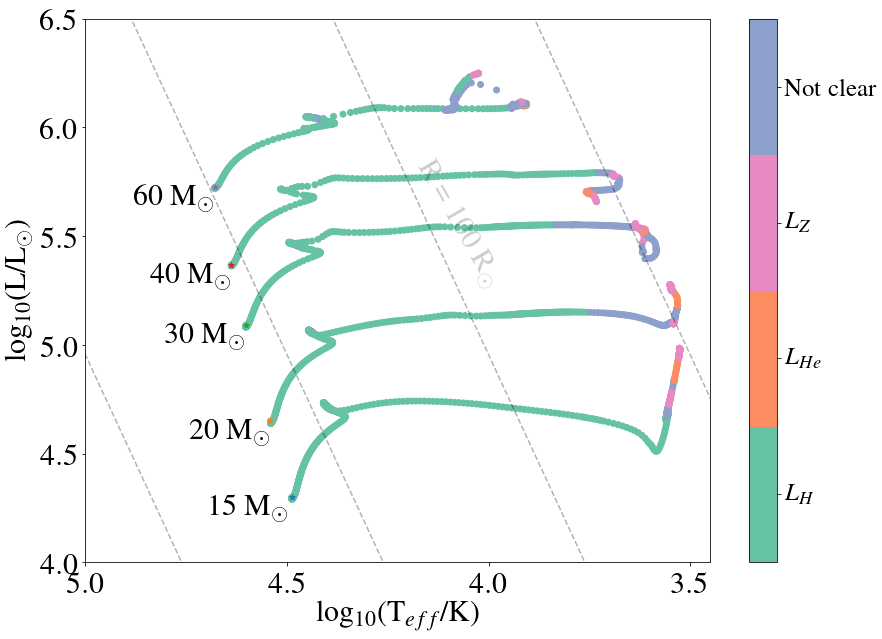

In [ ]:
HR_diagram(histoy_list, xlim = (3.45,5.), ylim= (4.,6.5), VMIN =-0.5, VMAX = 3.5, Ldominant = True,
           colour_by = 'L_dominant', colour_label = '$L_{Z}$/$L_{tot}$')

## c) interpret

Here we're examining the amount of energy production that is exclusively due to the fusion of hydrogen, helium, and metals in high mass stellar models. We're looking at stars with 15, 20, 30, 40, and 60 Msun.  All of our models are evolved up to the end of core carbon burning.

There are a number of ways to visualize this information, one is shown below via several Hertzsprung-Russell diagrams.

In Fig., we see that hydrogen fusion luminosity dominates during the main sequence (MS), as expected. After stars move along to their post MS phases, helium fusion begins to contribute on a similar level, along with energy production via the fusion of metals. 
If you look carefully, you might have noticed that metal burning appears to contribute to the luminosity earlier than expected (light blue in the bottom plot of  Fig. \ref{fig:p1_a}). This happens during the transitional phase, when the star is moving from H-shel burning to core He burning. At this point, the core He burning is ramping up. This includes Carbon alpha capture ($^{12}C(\alpha, \gamma) ^{16}O$), which MESA counts as a metal burning reaction (while it really shouldn't).
 
Another way to examine this is shown below in Fig. \ref{fig:p1_a2}, where points are coloured according to the dominant source of energy production.
From Fig. \ref{fig:p1_a2} it is immediately apparent that metal and helium fusion only really become dominant sources briefly near the end of the evolution. 
This shows that hydrogen (shell) burning  is the dominant source of the stars luminosity through most of its evolution. There is no clearly dominant source (defined here as one Luminosity contributes more than 50\% of the total luminosity) for significant stretches of the evolution.


*** 
# Problem 2a Stellar winds

In [ ]:
#read data
history15_Dutch = Table.read(proj_dir +'/hw4_models/M15_HW4_Dutch/history.data',format='csv',header_start = 4, data_start=5, delimiter = ' ')
history20_Dutch = Table.read(proj_dir +'/hw4_models/M20_HW4_Dutch/history.data',format='csv',header_start = 4, data_start=5, delimiter = ' ')
history30_Dutch = Table.read(proj_dir +'/hw4_models/M30_HW4_Dutch/history.data',format='csv',header_start = 4, data_start=5, delimiter = ' ')
history40_Dutch = Table.read(proj_dir +'/hw4_models/M40_HW4_Dutch/history.data',format='csv',header_start = 4, data_start=5, delimiter = ' ')
history60_Dutch = Table.read(proj_dir +'/hw4_models/M60_HW4_Dutch/history.data',format='csv',header_start = 4, data_start=5, delimiter = ' ')


history15_Dutch.info()



<Table length=838>
         name           dtype 
---------------------- -------
          model_number   int64
             num_zones   int64
              star_age float64
                log_dt float64
             star_mass float64
            log_xmstar float64
          log_abs_mdot float64
        mass_conv_core float64
          conv_mx1_top float64
          conv_mx1_bot float64
          conv_mx2_top float64
          conv_mx2_bot float64
               mx1_top float64
               mx1_bot float64
               mx2_top float64
               mx2_bot float64
                log_LH float64
               log_LHe float64
                log_LZ float64
              log_Lnuc float64
    log_Lnuc_sub_log_L float64
                    pp float64
                   cno float64
              tri_alfa float64
            epsnuc_M_1 float64
            epsnuc_M_2 float64
            epsnuc_M_3 float64
            epsnuc_M_4 float64
            epsnuc_M_5 float64
            epsnuc_M

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = plt.cm.plasma(np.linspace(0,1,15)) #3rd num is the number of colours Set2
newcmp = ListedColormap(colors)


#Plot the HR diagram with different colour values
def HR_diagram(histoy_list, xlim = (None, None), ylim = (None,None),  VMIN =-3, VMAX = 0, 
               colour_by = 'center_h1', colour_label = 'kleur',save_loc = proj_dir + '/hw4sol/plots/',
              label_list = ['None']):
    
    kleur = colour_by
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
    
        ##plot lines
        if i == 0:
            scat = ax.scatter(hist['log_Teff'],  hist['log_L'] , label= label_list[i],
                    c = hist[kleur], vmin= VMIN, vmax = VMAX, cmap = newcmp, zorder = 20)
            ax.scatter(hist['log_Teff'][0],  hist['log_L'][0] , marker = '*') #log_Teff
            ax.text(hist['log_Teff'][0],  hist['log_L'][0] , np.str(np.round(hist['star_mass'][0],0))+'M$_{\odot}$' , ha='right', va='top') #log_Teff
        else: #for no winds
            ax.plot(hist['log_Teff'],  hist['log_L'], label= label_list[i],
                    color = 'grey', lw = 7,ls='--', zorder=21, alpha = 0.75) #log_Teff

    ###############
    ### Add lines of constant radii
    log_Ts = np.arange(min(hist['log_Teff'])-2, max(hist['log_Teff'])+2, 0.1) #Array of log temperature values
    for i, logr in enumerate([-1,0,1,2,3]): #Loop over radii
        ax.plot(log_Ts, const_Rlines(log_Ts, logr), c='k', alpha = 0.3, linestyle='--')
        # Plot text
        ax.text(4.2, const_Rlines(4.2, logr), 'R = '+ str(np.round( 10**logr,2) ) +' R$_{\odot}$',
                 rotation=-80, alpha = 0.2).set_clip_on(True)
     
    #colorbar
    cb = fig.colorbar(scat, ax=ax)
    cb.set_label(colour_by.replace('_', ' '), size = 25)
    cb.set_label(colour_label, size = 25)
    cb.ax.tick_params(labelsize=25)
    
    
    # Plot values
    ax.set_ylabel('log$_{10}$(L/L$_{\odot}$)')
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)')
    plt.tick_params(axis='both', which='major')
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.gca().invert_xaxis()    
    plt.legend(loc = 'upper left')
    plt.savefig(save_loc +'/HR_'+colour_by+np.str(np.round(hist['star_mass'][0],0))+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()




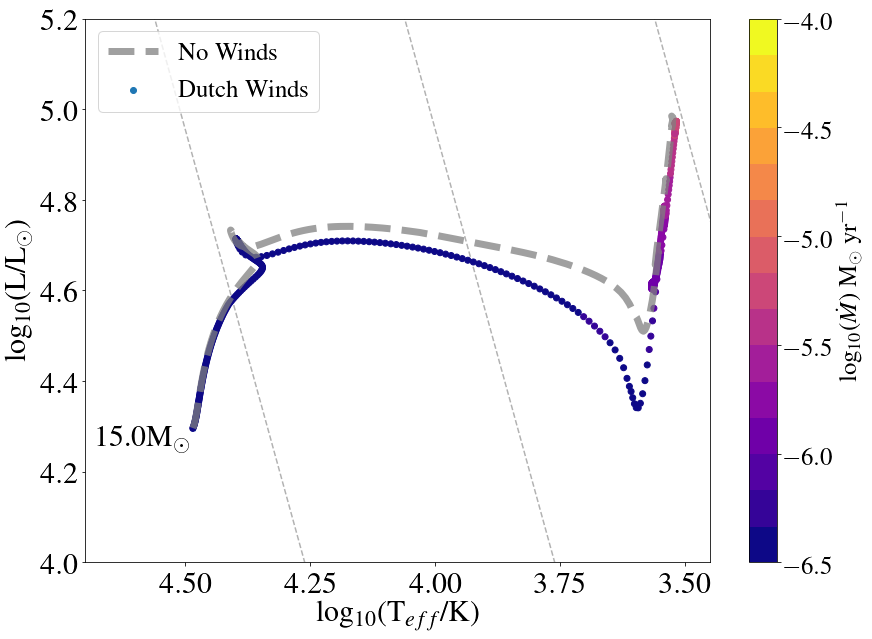

In [ ]:
labels   = ['Dutch Winds', 'No Winds']
HR_diagram([history15_Dutch, history15], xlim = (3.45,4.7), ylim= (4.,5.2), VMIN =-6.5, VMAX = -4,
           colour_by = 'log_abs_mdot', colour_label = 'log$_{10}$($\dot{M}$) M$_{\odot}$ yr$^{-1}$', label_list = labels)



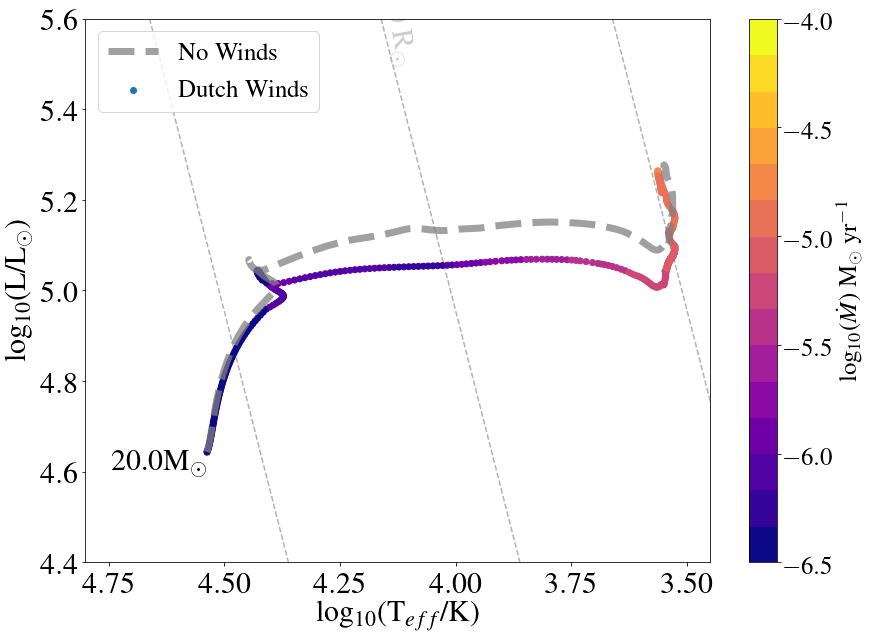

In [ ]:
labels   = ['Dutch Winds', 'No Winds']
HR_diagram([history20_Dutch, history20], xlim = (3.45,4.8), ylim= (4.4,5.6), VMIN =-6.5, VMAX = -4,
           colour_by = 'log_abs_mdot', colour_label = 'log$_{10}$($\dot{M}$) M$_{\odot}$ yr$^{-1}$', label_list = labels)


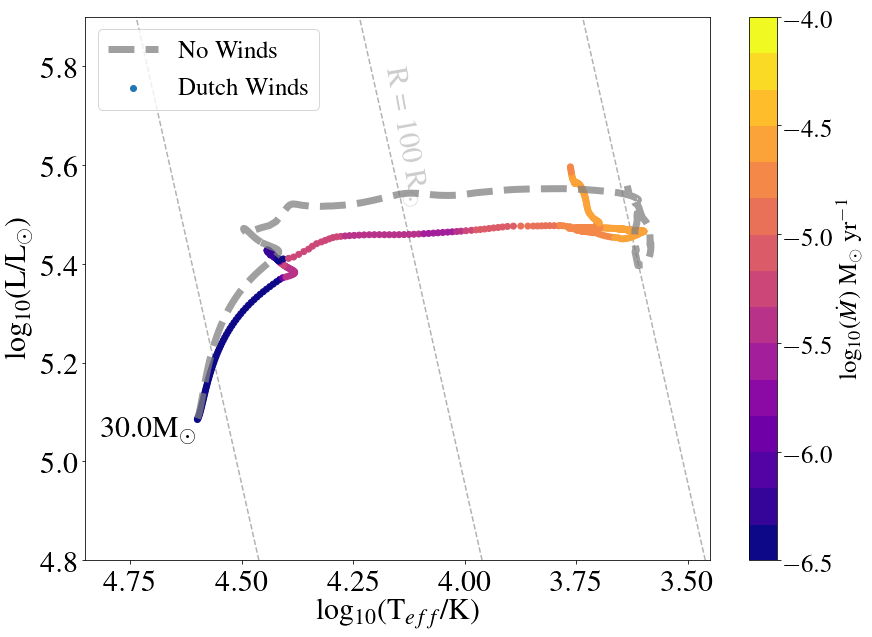

In [ ]:
labels   = ['Dutch Winds', 'No Winds']
HR_diagram([history30_Dutch, history30], xlim = (3.45,4.85), ylim= (4.8,5.9), VMIN =-6.5, VMAX = -4,
           colour_by = 'log_abs_mdot', colour_label = 'log$_{10}$($\dot{M}$) M$_{\odot}$ yr$^{-1}$', label_list = labels)


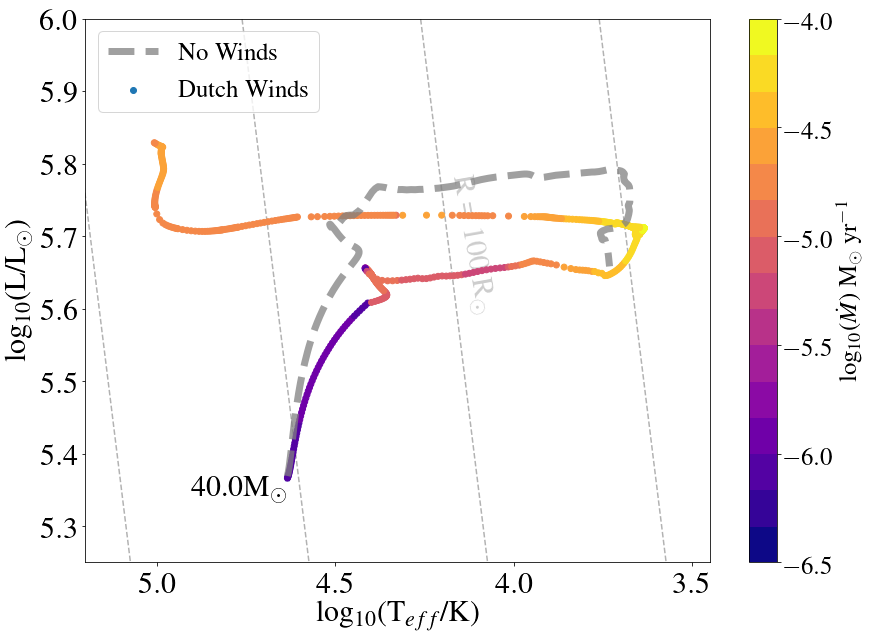

In [ ]:
labels   = ['Dutch Winds', 'No Winds']
HR_diagram([history40_Dutch, history40], xlim = (3.45,5.2), ylim= (5.25,6.0), VMIN =-6.5, VMAX = -4,
           colour_by = 'log_abs_mdot', colour_label = 'log$_{10}$($\dot{M}$) M$_{\odot}$ yr$^{-1}$', label_list = labels)


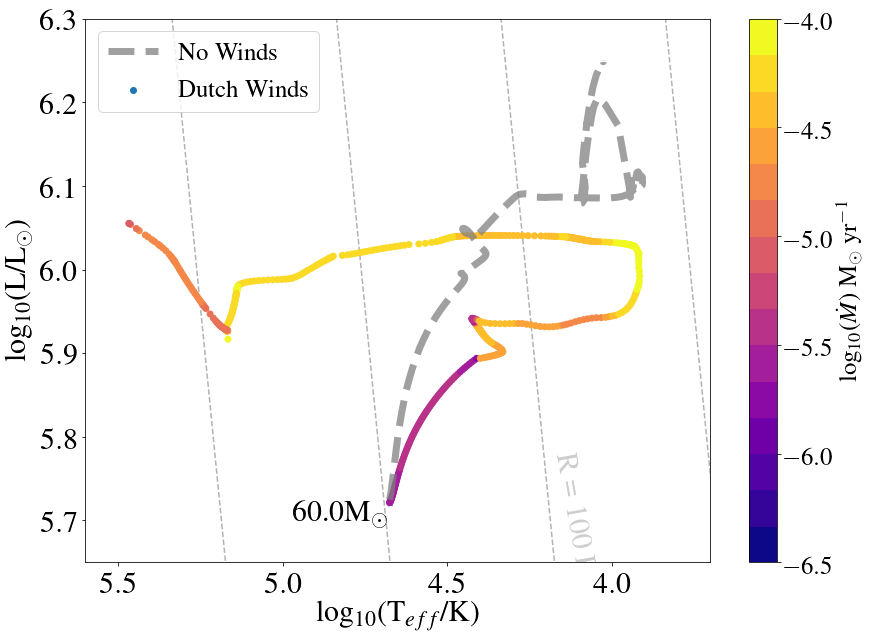

In [ ]:
labels   = ['Dutch Winds', 'No Winds']
HR_diagram([history60_Dutch, history60], xlim = (3.7,5.6), ylim= (5.65,6.3), VMIN =-6.5, VMAX = -4,
           colour_by = 'log_abs_mdot', colour_label = 'log$_{10}$($\dot{M}$) M$_{\odot}$ yr$^{-1}$', label_list = labels)


# Problem 2b Surface abundances

In [ ]:
history60_Dutch.info()

<Table length=763>
         name           dtype 
---------------------- -------
          model_number   int64
             num_zones   int64
              star_age float64
                log_dt float64
             star_mass float64
            log_xmstar float64
          log_abs_mdot float64
        mass_conv_core float64
          conv_mx1_top float64
          conv_mx1_bot float64
          conv_mx2_top float64
          conv_mx2_bot float64
               mx1_top float64
               mx1_bot float64
               mx2_top float64
               mx2_bot float64
                log_LH float64
               log_LHe float64
                log_LZ float64
              log_Lnuc float64
    log_Lnuc_sub_log_L float64
                    pp float64
                   cno float64
              tri_alfa float64
            epsnuc_M_1 float64
            epsnuc_M_2 float64
            epsnuc_M_3 float64
            epsnuc_M_4 float64
            epsnuc_M_5 float64
            epsnuc_M

In [ ]:
def plot_abundance_time(histoy_list, abund = 'surface_he4', ylab = 'He 4'):
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
        
        plt.plot(hist['star_age']/hist['star_age'][-1], hist[abund], 
                 label = np.str(np.round(hist['star_mass'][0],0))+'M$_{\odot}$')

    # Plot values
    ax.set_xlabel('fraction of star age to $^{12}$C exhaustion')
    ax.set_ylabel('surface abundance ' + ylab)
    plt.tick_params(axis='both', which='major')
    plt.xlim(0.8, 1.0)
#     plt.ylim(ylim)
    plt.yscale('log')

    plt.legend( )
    plt.savefig(save_loc +'/surfaceAbund'+abund+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()


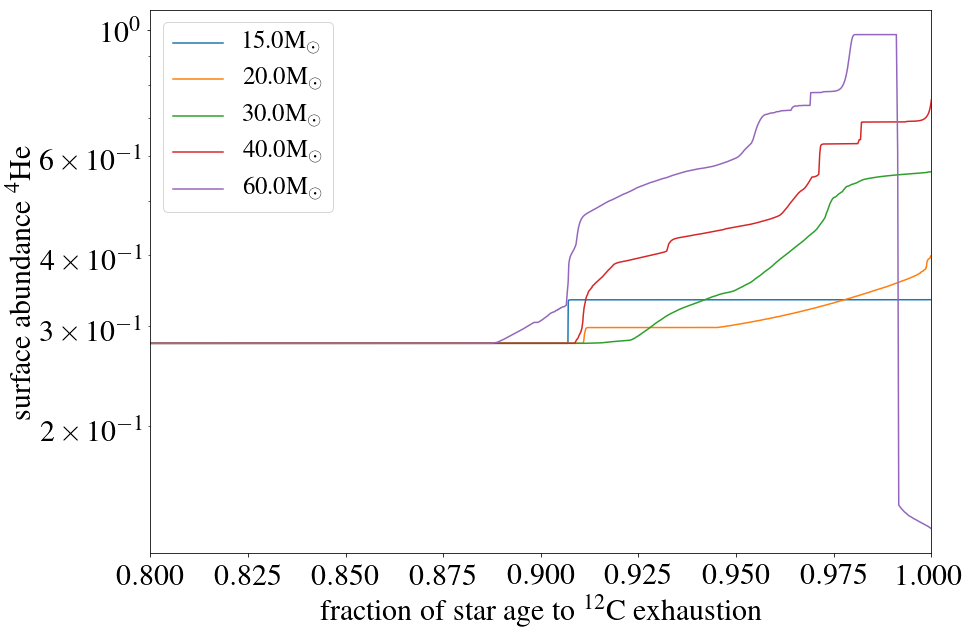

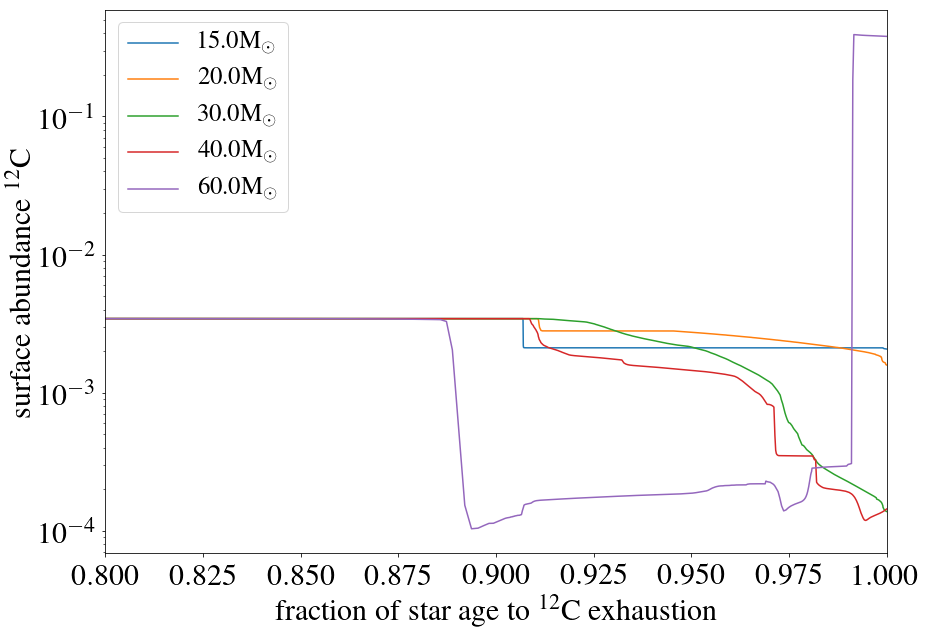

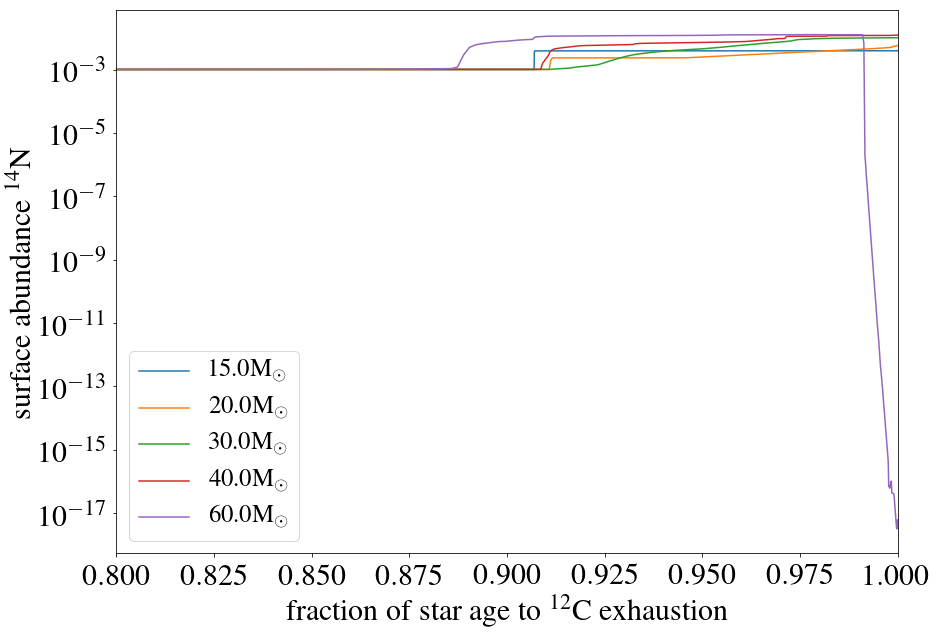

In [ ]:
plot_abundance_time(histoy_list, abund = 'surface_he4', ylab = '$^{4}$He')
plot_abundance_time(histoy_list, abund = 'surface_c12', ylab = '$^{12}$C')
plot_abundance_time(histoy_list, abund = 'surface_n14', ylab = '$^{14}$N')

In [ ]:

#Plot the HR diagram with different colour values
def HR_diagram(histoy_list, xlim = (None, None), ylim = (None,None),  VMIN =-3, VMAX = 0,
               colour_by = 'center_h1', colour_label = 'kleur',save_loc = proj_dir + '/hw4sol/plots/'):
    
    kleur = colour_by
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
        
        #Extra column
        hist['N_C'] = hist['surface_n14']/hist['surface_c12']
            
        ##plot lines
        scat = ax.scatter(hist['log_Teff'],  hist['log_L'] , label= hist_names[i],
                c = hist[kleur], vmin= VMIN, vmax = VMAX)
        ax.scatter(hist['log_Teff'][0],  hist['log_L'][0] , marker = '*') #log_Teff
        ax.text(hist['log_Teff'][0],  hist['log_L'][0] , hist_names[i], ha='right', va='top') #log_Teff

    ###############
    ### Add lines of constant radii
    log_Ts = np.arange(min(hist['log_Teff'])-2, max(hist['log_Teff'])+2, 0.1) #Array of log temperature values
    for i, logr in enumerate([-1,0,1,2,3]): #Loop over radii
        ax.plot(log_Ts, const_Rlines(log_Ts, logr), c='k', alpha = 0.3, linestyle='--')
        # Plot text
        ax.text(4.2, const_Rlines(4.2, logr), 'R = '+ str(np.round( 10**logr,2) ) +' R$_{\odot}$',
                 rotation=-60, alpha = 0.2).set_clip_on(True)
     
    #colorbar
    cb = fig.colorbar(scat, ax=ax)
    cb.set_label(colour_by.replace('_', ' '), size = 25)
    cb.set_label(colour_label, size = 25)
    cb.ax.tick_params(labelsize=20)
    
    # Show WR region
    WR_i1 = next(ind for ind,x in enumerate(history40_Dutch['surface_h1']) if x < 0.3)
    WR_i2 = next(ind for ind,x in enumerate(history60_Dutch['surface_h1']) if x < 0.3)
    T_array = np.linspace(history40_Dutch['log_Teff'][WR_i1]+0.05, 4., num =50)

    dx = history40_Dutch['log_Teff'][WR_i1] - history60_Dutch['log_Teff'][WR_i2]
    dy = history40_Dutch['log_L'][WR_i1] - history60_Dutch['log_L'][WR_i2]
    y_line = (dy/dx)*T_array + 16
    plt.plot(T_array, y_line , c = 'pink')
    plt.fill_between(x = T_array, y1 =y_line, y2 = 7,zorder = 0,
                     color='r',alpha=0.1,edgecolor='blue',hatch='/', lw = 0)
    plt.fill_between(x = np.linspace(6,history40_Dutch['log_Teff'][WR_i1]+0.05),zorder = 0,
                     y1 =y_line[0], y2 = 7,color='r',alpha=0.1,edgecolor='blue',hatch='/', lw = 0.0)
    
    
    # Plot values
    ax.set_ylabel('log$_{10}$(L/L$_{\odot}$)')
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)')
    plt.tick_params(axis='both', which='major')
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.gca().invert_xaxis()    
#     plt.legend( )
    plt.savefig(save_loc +'/HR_'+colour_by+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()




In [ ]:
histoy_list = [history15_Dutch, history20_Dutch, history30_Dutch, history40_Dutch, history60_Dutch]
HistNameList   = ['15 M$_{\odot}$', '20 M$_{\odot}$', '30 M$_{\odot}$', '40 M$_{\odot}$', '60 M$_{\odot}$']
colors = plt.cm.plasma(np.linspace(0,1,4)) #3rd num is the number of colours Set2

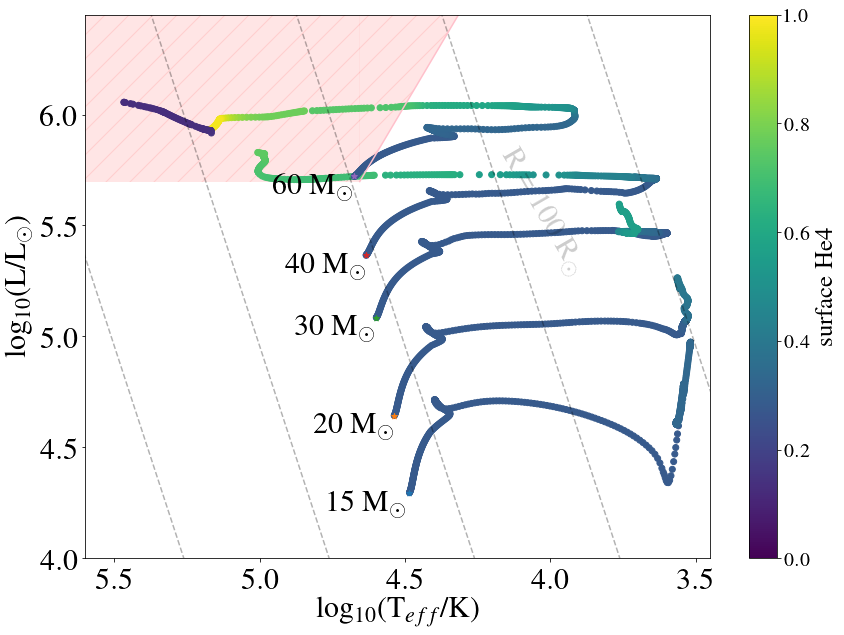

In [ ]:
# He
HR_diagram(histoy_list, xlim = (3.45,5.6), ylim= (4.,6.45), VMIN =0, VMAX = 1,
           colour_by = 'surface_he4', colour_label = 'surface He4')

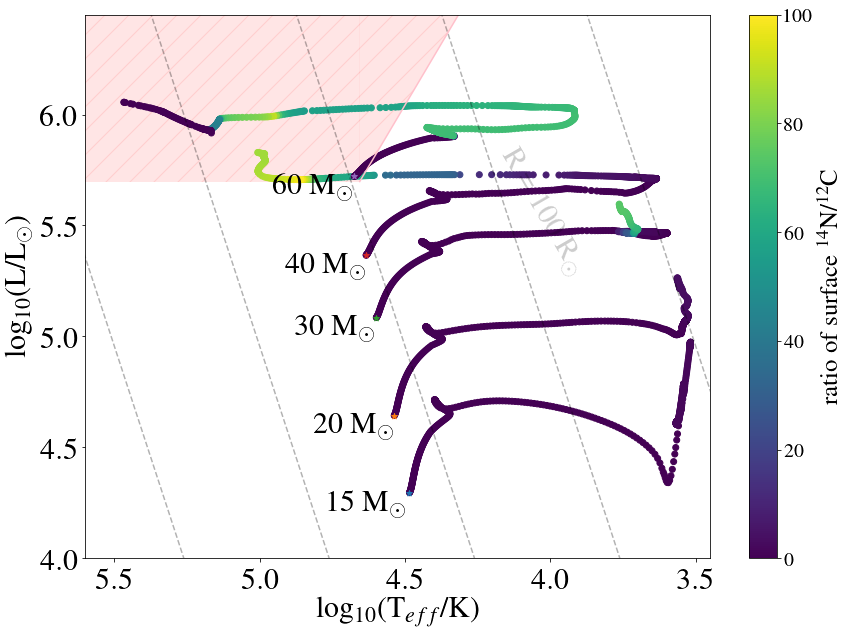

In [ ]:
# ratio Nitrogen over Carbon
HR_diagram(histoy_list, xlim = (3.45,5.6), ylim= (4.,6.45), VMIN =0, VMAX = 100,
           colour_by = 'N_C', colour_label = 'ratio of surface $^{14}$N/$^{12}$C')

# surface_h1 < 0.3


# 3 Evolution of massive stars with mass loss

In [62]:
# Read in the new data for our higher mass star with mass loss
M50_DSF1_hist_data = mr.MesaData('data/M50_overshoot0_DSF1p0/LOGS/history.data')
M50_DSF05_hist_data = mr.MesaData('data/M50_overshoot0_DSF0p5/LOGS/history.data')
M50_DSF01_hist_data = mr.MesaData('data/M50_overshoot0_DSF0p1/LOGS/history.data')

print(M50_DSF1_hist_data.bulk_names)

('model_number', 'num_zones', 'star_age', 'log_dt', 'star_mass', 'log_xmstar', 'log_abs_mdot', 'mass_conv_core', 'conv_mx1_top', 'conv_mx1_bot', 'conv_mx2_top', 'conv_mx2_bot', 'mx1_top', 'mx1_bot', 'mx2_top', 'mx2_bot', 'mix_type_1', 'mix_qtop_1', 'mix_type_2', 'mix_qtop_2', 'mix_type_3', 'mix_qtop_3', 'mix_type_4', 'mix_qtop_4', 'mix_type_5', 'mix_qtop_5', 'mix_type_6', 'mix_qtop_6', 'mix_type_7', 'mix_qtop_7', 'mix_type_8', 'mix_qtop_8', 'mix_type_9', 'mix_qtop_9', 'mix_type_10', 'mix_qtop_10', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'pp', 'cno', 'tri_alfa', 'epsnuc_M_1', 'epsnuc_M_2', 'epsnuc_M_3', 'epsnuc_M_4', 'epsnuc_M_5', 'epsnuc_M_6', 'epsnuc_M_7', 'epsnuc_M_8', 'burn_type_1', 'burn_qtop_1', 'burn_type_2', 'burn_qtop_2', 'burn_type_3', 'burn_qtop_3', 'burn_type_4', 'burn_qtop_4', 'burn_type_5', 'burn_qtop_5', 'burn_type_6', 'burn_qtop_6', 'burn_type_7', 'burn_qtop_7', 'burn_type_8', 'burn_qtop_8', 'burn_type_9', 'burn_qtop_9', 'burn_type_10', 'burn_qtop_10', 'he_core_mass',

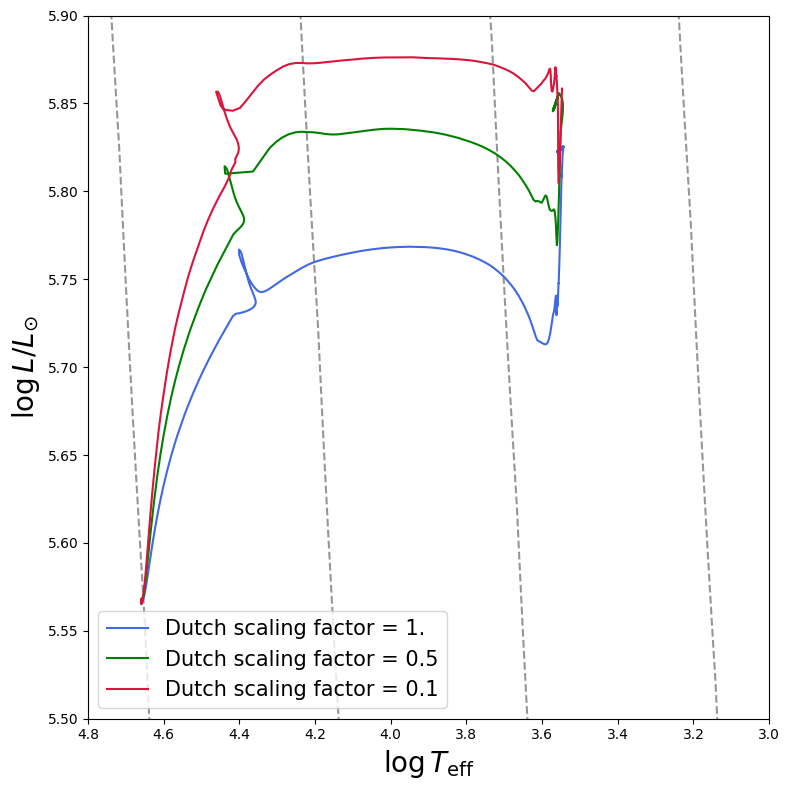

In [63]:
plot_HR_with_radius_contours(list_of_hist_data = [M50_DSF1_hist_data, M50_DSF05_hist_data, M50_DSF01_hist_data],
                            label_list = ['Dutch scaling factor = 1.', 'Dutch scaling factor = 0.5', 'Dutch scaling factor = 0.1'],
                            save_path='plots/M50_HR_diagram_winds.png',
                            xlim=(4.8, 3), ylim=(5.5, 5.9)
                            )



### Helium abundance versus stellar age

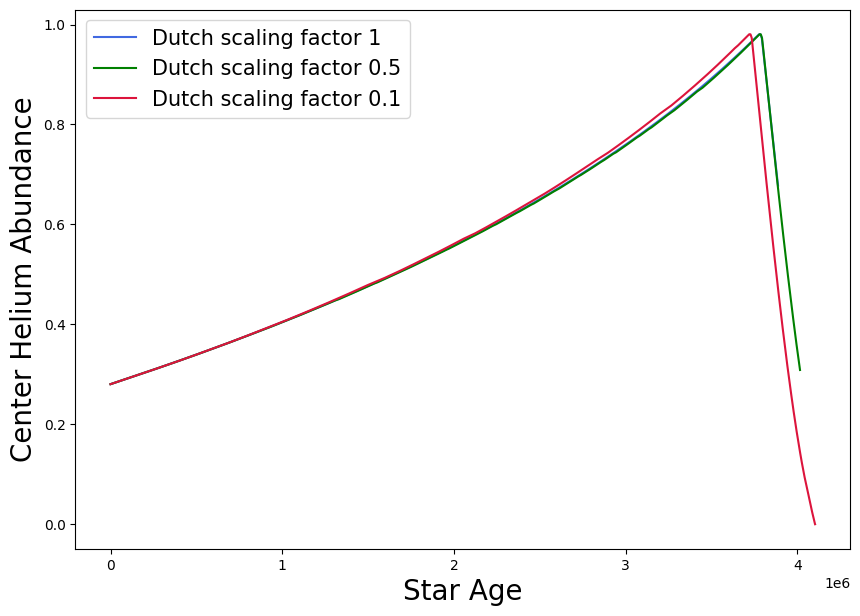

In [64]:
fig, ax = plt.subplots(figsize = (10,7))

##########
# Select the data to plot
for histdata, label, colors in zip([M50_DSF1_hist_data, M50_DSF05_hist_data, M50_DSF01_hist_data],
                                 ['Dutch scaling factor 1', 'Dutch scaling factor 0.5', 'Dutch scaling factor 0.1'],
                                 ['royalblue', 'green', 'crimson']):
    plt.plot(histdata.star_age, histdata.center_he4, label = label, color = colors)

# 'log_center_T', 'log_center_Rho',
plt.legend(fontsize = 15)
plt.xlabel("Star Age", fontsize = 20 )
plt.ylabel("Center Helium Abundance", fontsize = 20 )
plt.savefig('plots/M50_central_He.png', bbox_inches = 'tight')
plt.show()

Core properties didn't change much when changing the winds (which is an external thing!)

### Plot surface abundances

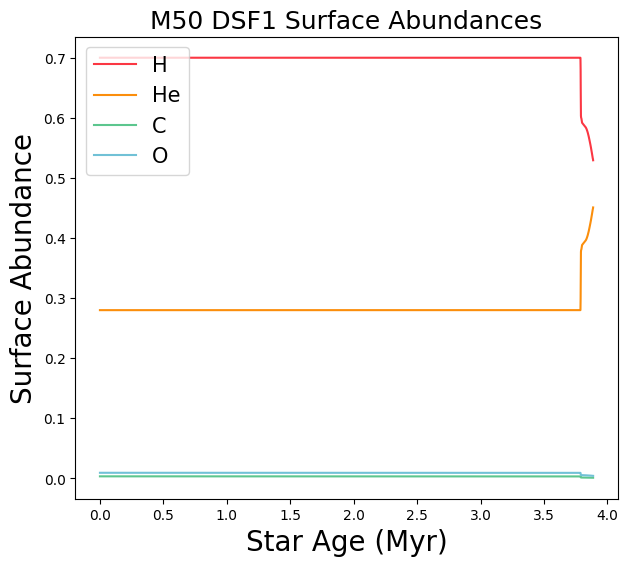

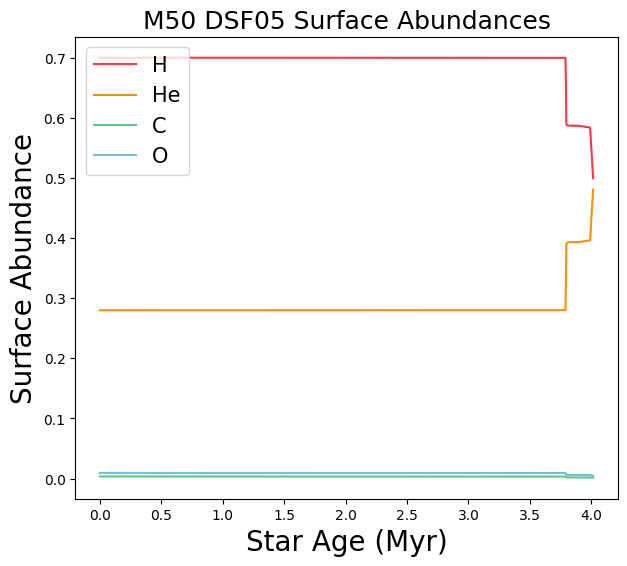

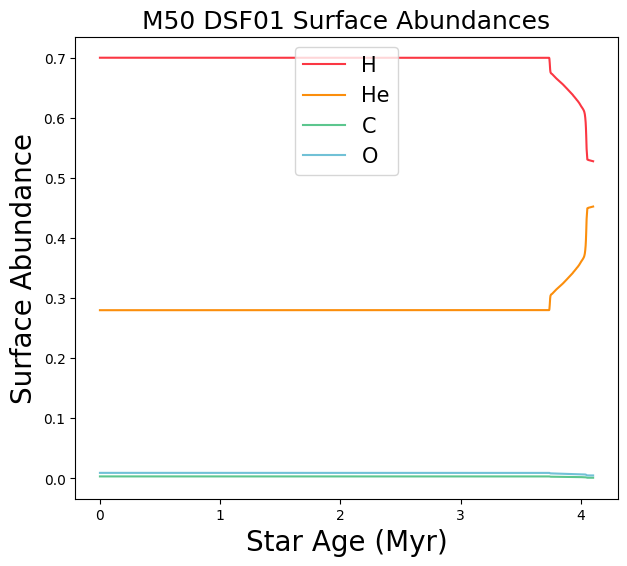

In [65]:
def plot_surface_abundances(histdata, var_name = 'DSF05'):
    fig, ax = plt.subplots(figsize = (7,6))

    ##########
    # Select the data to plot
    plt.plot(histdata.star_age*1e-6, histdata.surface_h1, label = 'H', color = '#FB3743')
    plt.plot(histdata.star_age*1e-6, histdata.surface_he4, label = 'He', color = '#FB8E0C')
    plt.plot(histdata.star_age*1e-6, histdata.surface_c12, label = 'C', color = '#5CC68E')
    plt.plot(histdata.star_age*1e-6, histdata.surface_o16, label = 'O', color = '#71C1D6')

    plt.title(f"M50 {var_name} Surface Abundances", fontsize = 18)
    plt.legend(fontsize = 15)
    plt.xlabel("Star Age (Myr)", fontsize = 20 )
    plt.ylabel("Surface Abundance", fontsize = 20 )
    plt.savefig(f'plots/M50_{var_name}_surface_abundances.png', bbox_inches = 'tight')
    plt.show()

plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')
plot_surface_abundances(M50_DSF05_hist_data, var_name='DSF05')
plot_surface_abundances(M50_DSF01_hist_data, var_name='DSF01')



Surface abundances change much more when you change the winds! I.e. with stronger winds, the stars become less H rich and more He rich in their envelope. 

### Extra: abundance profile beyond core He exhaust:

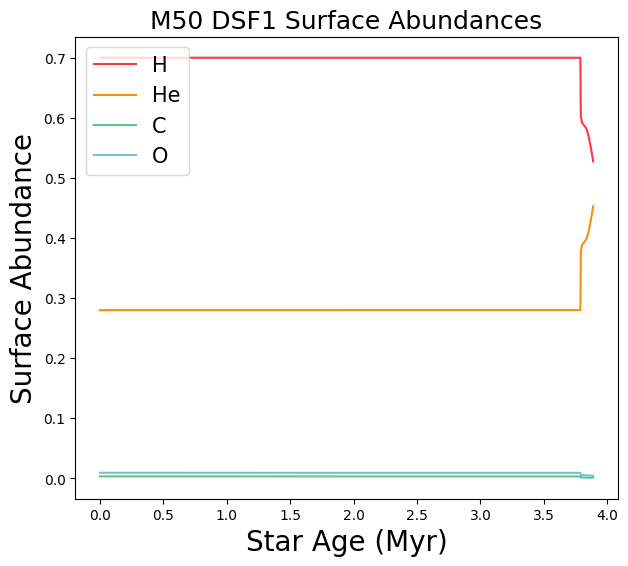

In [66]:
# Re-read in to load the newest data
M50_DSF1_hist_data = mr.MesaData('data/M50_overshoot0_DSF1p0/LOGS/history.data')

# Plot it
plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')
